# THƯ VIỆN

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, r2_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from datetime import datetime as dt

In [2]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression

from tensorflow import keras, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks

# ĐỌC VÀ CHIA DỮ LIỆU

In [3]:
train_values = pd.read_csv("train_values.csv")
train_labels = pd.read_csv("train_labels.csv")
test_values = pd.read_csv("test_values.csv")
submission_format = pd.read_csv("submission_format.csv")

In [4]:
nepal_data = train_values.merge(train_labels, how='inner', on='building_id')
len(nepal_data)

260601

In [5]:
x = pd.read_csv("train_values.csv", index_col="building_id")
y = pd.read_csv("train_labels.csv", index_col="building_id") - 1
print(len(x))
print(len(y))

260601
260601


In [6]:
scaler = StandardScaler()

* one hot encode và scale

In [7]:
encoded_temp = pd.get_dummies(x["count_floors_pre_eq"], prefix="count_floors").astype(int)
X_encoded = pd.get_dummies(x, dtype=int).drop(columns="count_floors_pre_eq")

for temp_col in encoded_temp.columns:
    X_encoded[temp_col] = encoded_temp[temp_col]

X0 = X_encoded.copy(deep=True)
scaled_X_encoded = scaler.fit_transform(X0)

pca = PCA(n_components=10)
# PCA 10 chiều với X_encoded 
pca_x_encoded = pca.fit_transform(X0)
# PCA 10 chiều với scaled_X_encoded
pca_scaled_x_encoded = pca.fit_transform(scaled_X_encoded)

# X_encoded là X áp dụng one hot encode
# scaled_X_encoded là X áp dụng one hot encode và scale

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=192)
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

208480
208480
52121
52121


In [9]:
x_encoded_train, x_encoded_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=192)
scaled_x_encoded_train, scaled_x_encoded_val, y_train, y_val = train_test_split(scaled_X_encoded, y, test_size=0.2, random_state=192)
pca_x_encoded_train, pca_x_encoded_val, y_train, y_val = train_test_split(pca_x_encoded, y, test_size=0.2, random_state=192)
pca_scaled_x_encoded_train, pca_scaled_x_encoded_val, y_train, y_val = train_test_split(pca_scaled_x_encoded, y, test_size=0.2, random_state=192)

* PCA 10 chiều với bộ scaled_X_encoded

In [10]:
corrs = X0.corr()
u,s,v = np.linalg.svd(corrs)
eig_values, eig_vectors = s, u

* Lượng thông tin mất mát khi bỏ đi còn 10 chiều: 66%

In [11]:
np.sum(eig_values[10:]) / np.sum(eig_values)

0.6594031508829912

* Lượng thông tin còn lại khi giữ lại 10 chiều: 34%

In [12]:
np.sum(eig_values[:10]) / np.sum(eig_values)

0.3405968491170085

# HQTT

In [13]:
int_data=['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
          'age', 'area_percentage', 'height_percentage', 'count_families']

x_train_int = x_train[int_data]
x_val_int = x_val[int_data]

print(len(x_train_int))
print(len(x_val_int))

208480
52121


In [14]:
start = dt.now()

regr = LinearRegression(fit_intercept=True)
regr.fit(x_train_int, y_train)
y_lr_pred = regr.predict(x_val_int)

running_secs = (dt.now() - start).microseconds
print(f"time: {running_secs} microsecs")

time: 21000 microsecs


In [15]:
print("Coefs: ", regr.coef_)
print("Intercept: ", regr.intercept_)

Coefs:  [[-4.43866462e-03  4.73623196e-05  1.59478174e-06  1.87923070e-04
  -1.91452176e-02  2.05069546e-02  9.67524642e-02]]
Intercept:  [1.19866305]


In [16]:
y_lr_pred

array([[0.98205558],
       [1.27733256],
       [1.35423117],
       ...,
       [1.29453597],
       [1.19521676],
       [1.14468617]])

In [17]:
# loss funcion
mse = mean_squared_error(y_val, y_lr_pred)
loss = mse * len(y_lr_pred)
loss /= 2
print("MSE: ", mse)
print("Loss: ", loss)

MSE:  0.3633325307241982
Loss:  9468.627416937967


# NB

In [18]:
class MixedNB2():
    def __init__(self, continuous_idx, binary_idx):
        self.continuous_idx = continuous_idx
        self.binary_idx = binary_idx

        self.gaussNB = GaussianNB()
        self.berNB = BernoulliNB()

    def fit(self, X, Y): # fit cả 2 model theo index truyền vào
        self.gaussNB.fit(X.iloc[:,self.continuous_idx], Y)
        self.berNB.fit(X.iloc[:, self.binary_idx], Y)

    def predict(self, X):
        y_pred = np.empty(X.shape[0])
        pred_probs_gauss = self.gaussNB.predict_joint_log_proba(X.iloc[:,self.continuous_idx]) # Lấy ra log(P(X|c)) ứng với mỗi xi trong X_test truyền vào (trong khoảng continuous_idx)
        pred_probs_bern = self.berNB.predict_joint_log_proba(X.iloc[:, self.binary_idx]) # Lấy ra log(P(X|c)) ứng với mỗi xi trong X_test truyền vào (trong khoảng binary_idx)
        log_posts = pred_probs_gauss + pred_probs_bern # Tính log(P(y|c)) 

        for i in range(len(log_posts)):
            y_pred[i] = np.argmax(log_posts[i])

        return np.array(y_pred, dtype=int)

In [19]:
continuous_cols = np.array(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'age', 'area_percentage', 'height_percentage', 'count_families'])
binary_cols = x_encoded_train[x_encoded_train.columns.difference(continuous_cols)].columns.to_numpy()

continuous_idxs = np.sort(x_encoded_train.columns.get_indexer(continuous_cols))
binary_idxs = np.sort(x_encoded_train.columns.get_indexer(binary_cols))

binary_idxs

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75], dtype=int64)

In [20]:
start = dt.now()

mNB2 = MixedNB2(continuous_idxs, binary_idxs)
mNB2.fit(x_encoded_train, y_train)
y_NB_pred = mNB2.predict(x_encoded_val)

running_secs = (dt.now() - start).microseconds
print(f"time: {running_secs} microsecs")

d:\Python\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Python\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time: 387949 microsecs


In [21]:
y_NB_pred

array([0, 1, 1, ..., 1, 0, 1])

In [22]:
print(metrics.classification_report(y_val, y_NB_pred, digits=4))

              precision    recall  f1-score   support

           0     0.4411    0.5277    0.4805      5056
           1     0.6185    0.7026    0.6579     29611
           2     0.5074    0.3615    0.4222     17454

    accuracy                         0.5714     52121
   macro avg     0.5223    0.5306    0.5202     52121
weighted avg     0.5641    0.5714    0.5617     52121



[[ 2668  2137   251]
 [ 2933 20805  5873]
 [  448 10697  6309]]


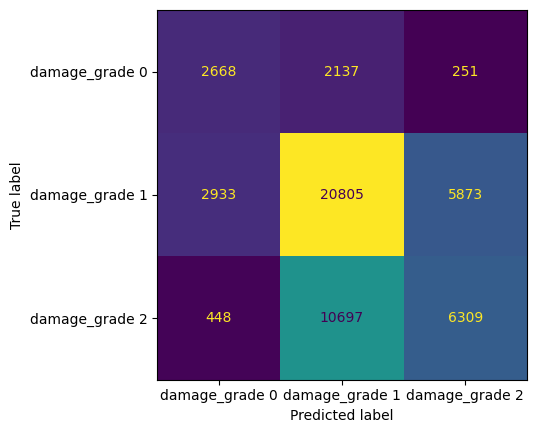

In [23]:
cm = metrics.confusion_matrix(y_val, y_NB_pred)
metrics.ConfusionMatrixDisplay(cm, display_labels=["damage_grade 0", "damage_grade 1", "damage_grade 2"]).plot(colorbar=False)
print(cm)

In [24]:
accuracy = accuracy_score(y_val, y_NB_pred)
precision = precision_score(y_val, y_NB_pred, average='weighted')
recall = recall_score(y_val, y_NB_pred, average='weighted')
f1 = f1_score(y_val, y_NB_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.5714011626791504
Precision: 0.56408447331542
Recall: 0.5714011626791504
F1 Score: 0.5617389709502685


# PCA NB

* Vì dữ liệu là liên tục nên dùng luôn Gaussian NB

In [25]:
start = dt.now()

gauss = GaussianNB()
gauss.fit(pca_x_encoded_train, y_train)
y_PCA_NB_pred = gauss.predict(pca_x_encoded_val)

running_secs = (dt.now() - start).microseconds
print(f"time: {running_secs} microsecs")

time: 55008 microsecs


d:\Python\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
y_PCA_NB_pred

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [27]:
print(metrics.classification_report(y_val, y_PCA_NB_pred, digits=4))

              precision    recall  f1-score   support

           0     0.4358    0.3799    0.4060      5056
           1     0.6016    0.7766    0.6780     29611
           2     0.5087    0.2766    0.3583     17454

    accuracy                         0.5707     52121
   macro avg     0.5154    0.4777    0.4808     52121
weighted avg     0.5544    0.5707    0.5446     52121



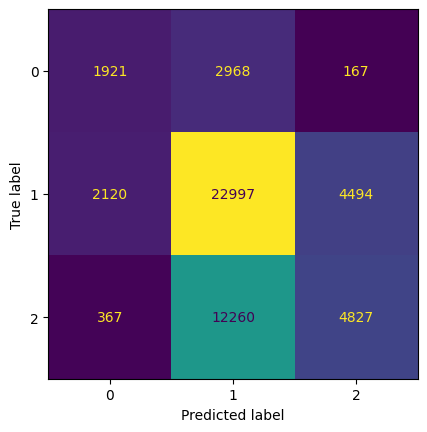

In [28]:
cm = metrics.confusion_matrix(y_val, y_PCA_NB_pred)
metrics.ConfusionMatrixDisplay(cm).plot(colorbar=False)

In [29]:
accuracy = accuracy_score(y_val, y_PCA_NB_pred)
precision = precision_score(y_val, y_PCA_NB_pred, average='weighted')
recall = recall_score(y_val, y_PCA_NB_pred, average='weighted')
f1 = f1_score(y_val, y_PCA_NB_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.5706912760691468
Precision: 0.5544350928322678
Recall: 0.5706912760691468
F1 Score: 0.5445697282778922


# MLR

In [30]:
start = dt.now()

MLR = LogisticRegression(multi_class='multinomial', solver='lbfgs')
MLR.fit(scaled_x_encoded_train, y_train)
y_MLR_pred = MLR.predict(scaled_x_encoded_val)

running_secs = (dt.now() - start).microseconds
print(f"time: {running_secs} microsecs")

d:\Python\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time: 833942 microsecs


In [31]:
y_MLR_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [32]:
print(metrics.classification_report(y_val, y_MLR_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5707    0.3032    0.3960      5056
           1     0.6025    0.8655    0.7104     29611
           2     0.5552    0.2194    0.3145     17454

    accuracy                         0.5946     52121
   macro avg     0.5761    0.4627    0.4736     52121
weighted avg     0.5836    0.5946    0.5473     52121



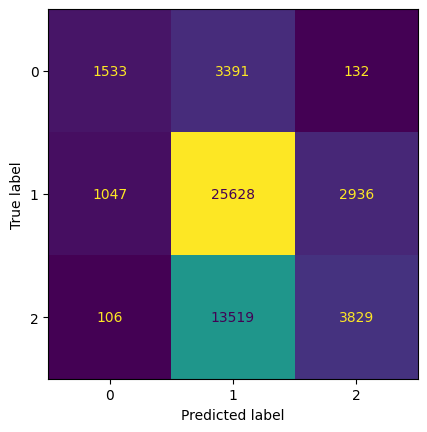

In [33]:
cm = metrics.confusion_matrix(y_val, y_MLR_pred)
metrics.ConfusionMatrixDisplay(cm).plot(colorbar=False)

In [34]:
accuracy = accuracy_score(y_val, y_MLR_pred)
precision = precision_score(y_val, y_MLR_pred, average='weighted')
recall = recall_score(y_val, y_MLR_pred, average='weighted')
f1 = f1_score(y_val, y_MLR_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.5945780011895397
Precision: 0.5835535722954701
Recall: 0.5945780011895397
F1 Score: 0.5473321340198936


# PCA MLR

In [35]:
start = dt.now()

MLR.fit(pca_scaled_x_encoded_train, y_train)
y_PCA_MLR_pred = MLR.predict(pca_scaled_x_encoded_val)

running_secs = (dt.now() - start).microseconds
print(f"time: {running_secs} microsecs")

d:\Python\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time: 306561 microsecs


In [36]:
y_PCA_MLR_pred

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [37]:
print(metrics.classification_report(y_val, y_PCA_MLR_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5387    0.2522    0.3435      5056
           1     0.5815    0.9131    0.7105     29611
           2     0.5078    0.0949    0.1599     17454

    accuracy                         0.5750     52121
   macro avg     0.5427    0.4200    0.4046     52121
weighted avg     0.5527    0.5750    0.4905     52121



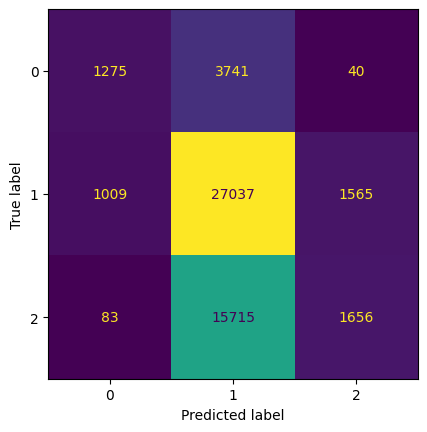

In [38]:
cm = metrics.confusion_matrix(y_val, y_PCA_MLR_pred)
metrics.ConfusionMatrixDisplay(cm).plot(colorbar=False)

In [39]:
accuracy = accuracy_score(y_val, y_PCA_MLR_pred)
precision = precision_score(y_val, y_PCA_MLR_pred, average='weighted')
recall = recall_score(y_val, y_PCA_MLR_pred, average='weighted')
f1 = f1_score(y_val, y_PCA_MLR_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.5749697818537634
Precision: 0.5526864361333524
Recall: 0.5749697818537634
F1 Score: 0.49053021605731756


# ANN

In [40]:
def gen_model(layers: list=[], input_shape: tuple=()):
    model = None
    if (len(layers) != 0):
        model = keras.models.Sequential(layers)
    else:
        model = keras.models.Sequential([
            keras.layers.Input(shape=input_shape),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(3, activation="softmax")
        ])

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

    return model


model = gen_model(input_shape=(10,))

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,059 (19.76 KB)

 Trainable params: 5,059 (19.76 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
early_stop = callbacks.EarlyStopping(monitor="loss", mode="min", min_delta=1e-5,patience=3, restore_best_weights=True, verbose=True)

In [43]:
start = dt.now()

history = model.fit(pca_x_encoded_train, to_categorical(y_train), epochs=50, callbacks=[early_stop])

running_secs = (dt.now() - start).microseconds
print(f"time: {running_secs} microsecs")

Epoch 1/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 4s 475us/step - acc: 0.4626 - loss: 5.6367
Epoch 2/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 3s 459us/step - acc: 0.4969 - loss: 1.7656
Epoch 3/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 3s 468us/step - acc: 0.5288 - loss: 1.0472
Epoch 4/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 3s 465us/step - acc: 0.5689 - loss: 0.8530
Epoch 5/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 3s 461us/step - acc: 0.5732 - loss: 0.8392
Epoch 6/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 3s 461us/step - acc: 0.5745 - loss: 0.8286
Epoch 7/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step - acc: 0.5724 - loss: 0.8245
Epoch 8/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 3s 453us/step - acc: 0.5758 - loss: 0.8204
Epoch 9/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 3s 465us/step - acc: 0.5737 - loss: 0.8182
Epoch 10/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 3s 479us/step - acc: 0.5746 - loss: 0.8179
Epoch 11/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 3s 461us/step - acc: 0.5761 - loss: 0.8149
Epoch 12/50
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 3s 468us/step - acc:

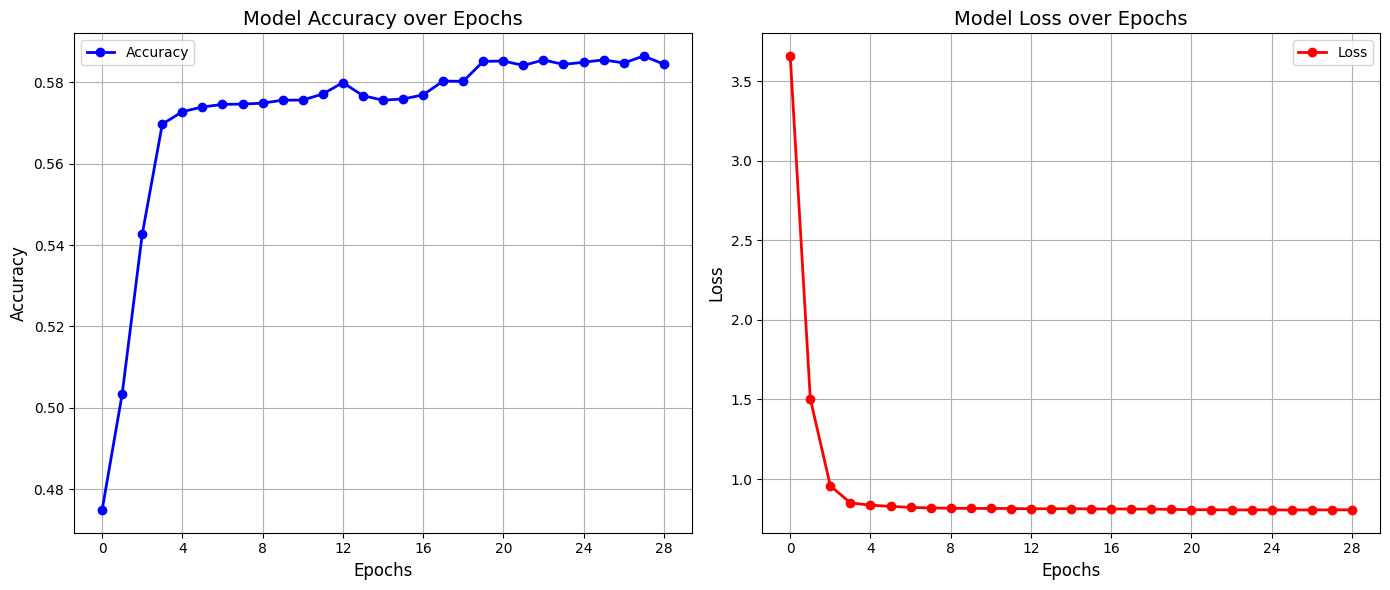

In [44]:
accs = history.history["acc"]
losses = history.history["loss"]

epochs = history.epoch

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accs, color="blue", marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('Model Accuracy over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend(['Accuracy'], loc='best')
plt.xticks(np.arange(min(epochs), max(epochs) + 1, 4))

plt.subplot(1, 2, 2)
plt.plot(epochs, losses, color="red", marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('Model Loss over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend(['Loss'], loc='best')
plt.xticks(np.arange(min(epochs), max(epochs) + 1, 4))

plt.tight_layout()
plt.show()

In [45]:
y_ANN_pred = np.array([np.argmax(pred) for pred in model.predict(pca_x_encoded_val)])
y_ANN_pred.shape

1629/1629 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step


(52121,)

In [46]:
print(metrics.classification_report(y_val, y_ANN_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5661    0.3287    0.4159      5056
           1     0.5960    0.8838    0.7119     29611
           2     0.5309    0.1605    0.2465     17454

    accuracy                         0.5877     52121
   macro avg     0.5643    0.4577    0.4581     52121
weighted avg     0.5713    0.5877    0.5273     52121



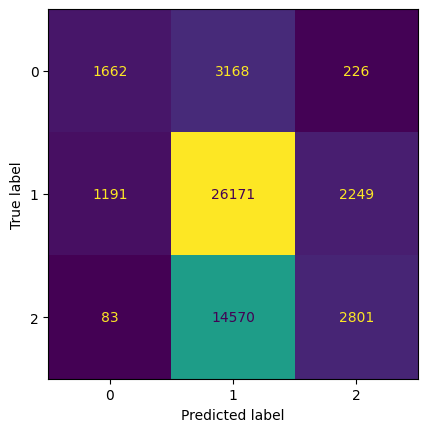

In [47]:
cm = metrics.confusion_matrix(y_val, y_ANN_pred)
metrics.ConfusionMatrixDisplay(cm).plot(colorbar=False)

In [48]:
accuracy = accuracy_score(y_val, y_ANN_pred)
precision = precision_score(y_val, y_ANN_pred, average='weighted')
recall = recall_score(y_val, y_ANN_pred, average='weighted')
f1 = f1_score(y_val, y_ANN_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.587747740833829
Precision: 0.5713111013817318
Recall: 0.587747740833829
F1 Score: 0.5273475281237575


# So sánh với HQTT

In [49]:
mse = mean_squared_error(y_NB_pred, y_lr_pred)
loss = mse * len(y_lr_pred)
loss /= 2
print("Với mô hình NB:")
print("MSE: ", mse)
print("Loss: ", loss)

Với mô hình NB:
MSE:  0.3205149049310632
Loss:  8352.778679955973


In [50]:
mse = mean_squared_error(y_PCA_NB_pred, y_lr_pred)
loss = mse * len(y_lr_pred)
loss /= 2
print("Với mô hình NB áp dụng PCA:")
print("MSE: ", mse)
print("Loss: ", loss)

Với mô hình NB áp dụng PCA:
MSE:  0.2527956921859018
Loss:  6587.982136210694


In [51]:
mse = mean_squared_error(y_MLR_pred, y_lr_pred)
loss = mse * len(y_lr_pred)
loss /= 2
print("Với mô hình MLR:")
print("MSE: ", mse)
print("Loss: ", loss)

Với mô hình MLR:
MSE:  0.19388335299846285
Loss:  5052.697120816441


In [52]:
mse = mean_squared_error(y_PCA_MLR_pred, y_lr_pred)
loss = mse * len(y_lr_pred)
loss /= 2
print("Với mô hình MLR áp dụng PCA:")
print("MSE: ", mse)
print("Loss: ", loss)

Với mô hình MLR áp dụng PCA:
MSE:  0.145955874716496
Loss:  3803.683073049244


In [53]:
mse = mean_squared_error(y_ANN_pred, y_lr_pred)
loss = mse * len(y_lr_pred)
loss /= 2
print("Với mô hình ANN:")
print("MSE: ", mse)
print("Loss: ", loss)

Với mô hình ANN:
MSE:  0.1893127090101349
Loss:  4933.5838531586205


In [59]:
count_less_than_2 = (y_lr_pred >= 2).sum()

print(len(y_lr_pred))
print(f"Số giá trị >= 2 trong dự đoán của mô hình HQTT: {count_less_than_2}")

52121
Số giá trị >= 2 trong dự đoán của mô hình HQTT: 0
